In [33]:
pip install CoolProp

In [28]:
import CoolProp.CoolProp as cp

class NuclearCycle:
    def __init__(self):
        self.fluid_CO2 = 'CO2'
        self.fluid_water = 'Water'

    def reactor(self, T_inlet_C):
        P_inlet = 6e6  # Inlet pressure (Pa)
        T_inlet = 350 + 273.15  # Inlet temeorature (K)
        T_outlet = 750 + 273.15  # Outlet temperature (K)
        m_dot = 81.5  # Mass flow rate (kg/s)
        power_output_th = 180e6  # Thermal power output (W)

        # Calculating properties at outlet
        h_inlet = cp.PropsSI('H', 'T', T_inlet, 'P', P_inlet, self.fluid_CO2)
        h_outlet = cp.PropsSI('H', 'T', T_outlet, 'P', P_inlet, self.fluid_CO2)
        s_inlet = cp.PropsSI('S', 'T', T_inlet, 'P', P_inlet, self.fluid_CO2)
        s_outlet = cp.PropsSI('S', 'T', T_outlet, 'P', P_inlet, self.fluid_CO2)
        delta_h = h_outlet - h_inlet

        m_dot_steam = power_output_th / delta_h  # Calculating steam mass flow based on energy conversion

        return {'T_outlet': T_outlet, 'P_outlet': P_inlet, 'h_outlet': h_outlet, 's_outlet': s_outlet, 'm_dot_CO2': m_dot, 'm_dot_steam': m_dot_steam}

    def heat_exchanger(self, T_hot_in_C, T_cold_in_C, P_hot_MPa, P_cold_MPa, m_dot_hot, m_dot_cold, effectiveness):
       T_hot_in = T_hot_in_C + 273.15
       T_cold_in = T_cold_in_C + 273.15
       P_hot = P_hot_MPa * 1e6
       P_cold = P_cold_MPa * 1e6

    # Specific heat capacities at inlet conditions
       cp_hot = cp.PropsSI('C', 'T', T_hot_in, 'P', P_hot, self.fluid_CO2)
       cp_cold = cp.PropsSI('C', 'T', T_cold_in, 'P', P_cold, self.fluid_water)

    # Calculating heat capacity rates
       Q_dot_hot = m_dot_hot * cp_hot
       Q_dot_cold = m_dot_cold * cp_cold
       C_min = min(Q_dot_hot, Q_dot_cold)
       Q_max = C_min * (T_hot_in - T_cold_in)

       Q_actual = effectiveness * Q_max

       # New outlet temperatures
       T_hot_out = T_hot_in - Q_actual / Q_dot_hot
       T_cold_out = T_cold_in + Q_actual / Q_dot_cold

    # Getting enthalpy and entropy at outlet conditions
       h_outlet_hot = cp.PropsSI('H', 'T', T_hot_out, 'P', P_hot, self.fluid_CO2)
       h_outlet_cold = cp.PropsSI('H', 'T', T_cold_out, 'P', P_cold, self.fluid_water)
       s_outlet_hot = cp.PropsSI('S', 'T', T_hot_out, 'P', P_hot, self.fluid_CO2)
       s_outlet_cold = cp.PropsSI('S', 'T', T_cold_out, 'P', P_cold, self.fluid_water)

       return {
        'T_hot_out': T_hot_out,
        'T_cold_out': T_cold_out,
        'h_outlet_hot': h_outlet_hot,
        'h_outlet_cold': h_outlet_cold,
        's_outlet_hot': s_outlet_hot,
        's_outlet_cold': s_outlet_cold,
        'm_dot_hot': m_dot_hot,
        'm_dot_steam': m_dot_cold  # Assuming m_dot_cold is the mass flow rate of steam
        }

    def pump(self, T_inlet_C, P_outlet_MPa, m_dot):
        P_inlet = 6e6  # Inlet pressure
        T_inlet = T_inlet_C + 273.15
        P_outlet = P_outlet_MPa * 1e6  # Outlet pressure
        T_outlet = 350 + 273.15  # Outlet temperature is set to 350°C in Kelvin

        eta_isentropic = 0.8  # Assuming Isentropic efficiency of the pump to be 0.8
        h_inlet = cp.PropsSI('H', 'T', T_inlet, 'P', P_inlet, self.fluid_CO2)
        s_inlet = cp.PropsSI('S', 'T', T_inlet, 'P', P_inlet, self.fluid_CO2)
        h_out_isentropic = cp.PropsSI('H', 'P', P_outlet, 'S', s_inlet, self.fluid_CO2)
        h_outlet = h_inlet + (h_out_isentropic - h_inlet) / eta_isentropic

        return {'T_outlet': T_outlet, 'P_outlet': P_outlet, 'h_outlet': h_outlet, 's_outlet': cp.PropsSI('S', 'T', T_outlet, 'P', P_outlet, self.fluid_CO2), 'm_dot': m_dot}

    def turbine(self, T_inlet_C, m_dot, power_output):
        P_inlet = 6e6
        P_outlet = 0.1e6  # Adjusted for a more realistic lower outlet pressure
        T_inlet = T_inlet_C + 273.15

        h_inlet = cp.PropsSI('H', 'T', T_inlet, 'P', P_inlet, self.fluid_water)
        s_inlet = cp.PropsSI('S', 'T', T_inlet, 'P', P_inlet, self.fluid_water)

        # Calculating outlet properties assuming isentropic expansion
        h_outlet_s = cp.PropsSI('H', 'S', s_inlet, 'P', P_outlet, self.fluid_water)
        h_outlet = h_inlet - (h_inlet - h_outlet_s) * 0.85  # Considering an isentropic efficiency of 0.85


        T_outlet = cp.PropsSI('T', 'H', h_outlet, 'P', P_outlet, self.fluid_water)
        s_outlet = cp.PropsSI('S', 'T', T_outlet, 'P', P_outlet, self.fluid_water)

        return {'T_outlet': T_outlet, 'P_outlet': P_outlet, 'h_outlet': h_outlet, 's_outlet': s_outlet, 'm_dot': m_dot}

    def recuperator(self, T_steam_outlet_C, T_cold_inlet_C, m_dot_turbine, effectiveness=0.8):
        P_steam = 6e6  # Pressure for steam side
        P_cold = 6e6  # Pressure for the cold side
        T_steam_inlet = T_steam_outlet_C + 273.15
        T_cold_inlet = T_cold_inlet_C + 273.15

    # Calculating properties of steam at the inlet
        cp_steam = cp.PropsSI('C', 'T', T_steam_inlet, 'P', P_steam, self.fluid_water)
        cp_cold = cp.PropsSI('C', 'T', T_cold_inlet, 'P', P_cold, self.fluid_water)

    # Adjusted mass flow rate for 10% losses
        m_dot_steam = m_dot_turbine * 0.9
        m_dot_cold = m_dot_steam  # Assuming same mass flow for simplification

    # Heat capacity rates
        Q_dot_steam = cp_steam * m_dot_steam
        Q_dot_cold = cp_cold * m_dot_cold
        C_min = min(Q_dot_steam, Q_dot_cold)

    # Maximum and actual heat transferred
        delta_T = T_steam_inlet - T_cold_inlet
        Q_max = C_min * delta_T
        Q_actual = effectiveness * Q_max

    # New outlet temperatures
        T_steam_outlet = T_steam_inlet - Q_actual / Q_dot_steam
        T_cold_outlet = T_cold_inlet + Q_actual / Q_dot_cold

    # Enthalpy and entropy at outlet conditions
        h_steam_outlet = cp.PropsSI('H', 'T', T_steam_outlet, 'P', P_steam, self.fluid_water)
        h_cold_outlet = cp.PropsSI('H', 'T', T_cold_outlet, 'P', P_cold, self.fluid_water)
        s_steam_outlet = cp.PropsSI('S', 'T', T_steam_outlet, 'P', P_steam, self.fluid_water)
        s_cold_outlet = cp.PropsSI('S', 'T', T_cold_outlet, 'P', P_cold, self.fluid_water)

        return {
        'T_steam_outlet': T_steam_outlet ,
        'T_cold_outlet': T_cold_outlet ,
        'h_steam_outlet': h_steam_outlet,
        'h_cold_outlet': h_cold_outlet,
        's_steam_outlet': s_steam_outlet,
        's_cold_outlet': s_cold_outlet,
        'm_dot_steam': m_dot_steam,
        'm_dot_cold': m_dot_cold
    }

    def reboiler(self, T_cold_out, T_reboiler_out, m_dot):
        T_reboiler_inlet = T_cold_out + 200 + 273.15
        T_reboiler_outlet = 540 + 273.15
        P_outlet = 13.8e6

        m_dot = 64
        s_outlet = cp.PropsSI('S', 'T', T_reboiler_outlet, 'P', P_outlet, self.fluid_water)
        h_outlet = cp.PropsSI('H', 'T', T_reboiler_outlet, 'P', P_outlet, self.fluid_water)

        return {'T_reboiler_outlet': T_reboiler_outlet, 'h_outlet': h_outlet, 's_outlet': s_outlet, 'm_dot': m_dot}

    def air_cooler_1(self, T_inlet_C, m_dot_recuperator, m_dot_reboiler):
       T_inlet = T_inlet_C + 273.15  # Convert Celsius to Kelvin
       P_inlet = 1e5  # Assume atmospheric pressure in Pa
       cooling_effect = 10  # Assume air cooler cools by 10 degrees Celsius
       T_outlet = T_inlet - cooling_effect
       m_dot_total = m_dot_recuperator + 0.5 * m_dot_reboiler  # Total mass flow combining both streams

       h_inlet = cp.PropsSI('H', 'T', T_inlet, 'P', P_inlet, self.fluid_water)
       h_outlet = cp.PropsSI('H', 'T', T_outlet, 'P', P_inlet, self.fluid_water)
       s_outlet = cp.PropsSI('S', 'T', T_outlet, 'P', P_inlet, self.fluid_water)

       return {
        'T_outlet': T_outlet ,
        'h_inlet': h_inlet,
        'h_outlet': h_outlet,
        's_outlet': s_outlet,
        'm_dot': m_dot_total
    }

    def condenser(self, T_inlet_C, m_dot, condenser_number):
        P_inlet = 0.1e6  # Inlet pressure (Pa)
        T_inlet = T_inlet_C + 273.15  # Convert Celsius to Kelvin
        P_outlet = P_inlet  # Outlet pressure same as inlet for simplicity

    # Adjust the cooling effect to ensure the condenser outlet is cooler than the air cooler outlet
        cooling_effect = 15 if condenser_number == 1 else 10  # Greater cooling for Condenser 1

        T_outlet = T_inlet - cooling_effect  # Cool the inlet temperature further

    # Assuming the condenser behaves isobarically
        h_outlet = cp.PropsSI('H', 'T', T_outlet, 'P', P_outlet, self.fluid_CO2)
        s_outlet = cp.PropsSI('S', 'T', T_outlet, 'P', P_outlet, self.fluid_CO2)

    # Return outlet properties and adjusted mass flow rate assuming some loss or none
        m_dot_outlet = m_dot * 0.99  # Assume 1% mass loss in condenser, for example

        return {
        'T_outlet': T_outlet - 273.15,  # Convert back to Celsius for consistency
        'h_outlet': h_outlet,
        's_outlet': s_outlet,
        'm_dot': m_dot_outlet
    }

    def air_cooler_2(self, T_inlet_K, m_dot, T_condenser1_outlet_K):
        P_inlet = 1e5  # Atmospheric pressure in Pa
        desired_cooling_effect = max(15, T_inlet_K - T_condenser1_outlet_K + 5)  # Logic to ensure additional cooling
        T_outlet = T_inlet_K - desired_cooling_effect

        h_inlet = cp.PropsSI('H', 'T', T_inlet_K, 'P', P_inlet, self.fluid_water)
        h_outlet = cp.PropsSI('H', 'T', T_outlet, 'P', P_inlet, self.fluid_water)
        s_outlet = cp.PropsSI('S', 'T', T_outlet, 'P', P_inlet, self.fluid_water)

        return {
        'T_outlet_K': T_outlet,  # Correctly return in Kelvin
        'h_inlet': h_inlet,
        'h_outlet': h_outlet,
        's_outlet': s_outlet,
        'm_dot': m_dot
    }

    def condenser_2(self, T_inlet_C, m_dot):
       P_inlet = 0.1e6  # Inlet pressure for condenser 2 (Pa)
       T_inlet = T_inlet_C + 273.15  # Convert Celsius to Kelvin
       P_outlet = P_inlet  # Outlet pressure same as inlet for simplicity
       cooling_effect = 15  # Cooling effect for Condenser 2
       T_outlet = T_inlet - cooling_effect  # Cool the inlet temperature further

       h_outlet = cp.PropsSI('H', 'T', T_outlet, 'P', P_outlet, self.fluid_water)
       s_outlet = cp.PropsSI('S', 'T', T_outlet, 'P', P_outlet, self.fluid_water)

       return {
        'T_outlet_C': T_outlet - 273.15,  # Convert back to Celsius for output
        'h_outlet': h_outlet,
        's_outlet': s_outlet,
        'm_dot': m_dot  # Assuming no mass loss in the condenser
    }

# Create an instance of the NuclearCycle class
nuclear_cycle = NuclearCycle()

# Execute reactor operations
reactor_out = nuclear_cycle.reactor(350)

# Execute heat exchanger operations
heat_exchanger_out = nuclear_cycle.heat_exchanger(
    T_hot_in_C=750,
    T_cold_in_C=350,
    P_hot_MPa=6,
    P_cold_MPa=6,
    m_dot_hot=reactor_out['m_dot_CO2'],
    m_dot_cold=reactor_out['m_dot_steam'],
    effectiveness=0.8
)

# Execute the pump operation
outlet_pressure_MPa = 6  # Desired outlet pressure in MPa
mass_flow_rate_kgs = 81.5  # Assuming mass flow rate from the reactor

pump_out = nuclear_cycle.pump(heat_exchanger_out['T_hot_out'], 6, reactor_out['m_dot_CO2']) # Execute the pump operation with the inlet temperature from the heat exchanger's hot fluid outlet

# Calculate the steam mass flow rate going to the turbine (80% of steam from the heat exchanger)
m_dot_turbine = 0.6 * heat_exchanger_out['m_dot_steam']

# Execute turbine operations with 15 MW power output
turbine_out = nuclear_cycle.turbine(heat_exchanger_out['T_cold_out'], m_dot_turbine, 15e6)

# Execute recuperator operations
recuperator_out = nuclear_cycle.recuperator(turbine_out['T_outlet'], 30, m_dot_turbine)  # 30°C as the secondary fluid inlet

# Execute reboiler operations
m_dot_in = 0.4 * heat_exchanger_out['m_dot_steam']
reboiler_out = nuclear_cycle.reboiler(540, 13.8e6, m_dot_in)

# Execute air cooler 1 operations

T_steam_outlet_C = turbine_out['T_outlet']
T_cold_inlet_C = 30  # Assuming cold inlet temperature for the recuperator
m_dot_turbine = turbine_out['m_dot'] * 0.9  # Assuming 10% loss

T_cold_out = recuperator_out['T_cold_outlet']  # Using the cold outlet temperature from recuperator as input
T_reboiler_out = 540  # Example output temperature for the reboiler
m_dot_reboiler_in = recuperator_out['m_dot_steam'] * 0.5  # 50% of steam from recuperator goes to reboiler

# Getting the outputs from each component necessary for the air cooler
recuperator_output = nuclear_cycle.recuperator(T_steam_outlet_C, T_cold_inlet_C, m_dot_turbine)
reboiler_output = nuclear_cycle.reboiler(T_cold_out, T_reboiler_out, m_dot_reboiler_in)

air_cooler_1_output = nuclear_cycle.air_cooler_1(
    T_inlet_C=recuperator_output['T_cold_outlet'],
    m_dot_recuperator=recuperator_output['m_dot_steam'],
    m_dot_reboiler=reboiler_output['m_dot']
)

# Execute Condenser 1 operations
condenser_1_output = nuclear_cycle.condenser(
    T_inlet_C=air_cooler_1_output['T_outlet'],
    m_dot=air_cooler_1_output['m_dot'],
    condenser_number=1  # Assuming this is Condenser 1
)

# Execute Air Cooler 2 operations
m_dot_air_cooler_2 = condenser_1_output['m_dot'] * 0.6

air_cooler_2_output = nuclear_cycle.air_cooler_2(
    T_inlet_K=condenser_1_output['T_outlet'] + 273.15,
    m_dot=m_dot_air_cooler_2,
    T_condenser1_outlet_K=condenser_1_output['T_outlet'] + 273.15
)

# Reinvoking Heat Exchanger with the returned mass flow
m_dot_back_to_heat_exchanger = condenser_1_output['m_dot'] * 0.4
returned_heat_exchanger_output = nuclear_cycle.heat_exchanger(
    T_hot_in_C=recuperator_out['T_steam_outlet'],
    T_cold_in_C=350,  # Initial cold inlet temperature
    P_hot_MPa=6,  # Assumed constant pressure
    P_cold_MPa=6,  # Assumed constant pressure
    m_dot_hot=m_dot_back_to_heat_exchanger,  # 40% of the flow from Condenser 1
    m_dot_cold=heat_exchanger_out['m_dot_steam'],  # Same as initial to maintain the cycle balance
    effectiveness=0.8  # Assuming constant effectiveness
)

# Execute Condenser 2 operations after Air Cooler 2
condenser_2_output = nuclear_cycle.condenser_2(
    T_inlet_C=air_cooler_2_output['T_outlet_K'] - 273.15,  # Convert Kelvin back to Celsius for the input
    m_dot=air_cooler_2_output['m_dot']
)

# Redirect the output from Condenser 2 back into the Recuperator
# Assuming some parameters for the reinvocation of the recuperator:
T_cold_in_C = 30  # Assuming cold inlet temperature

recuperator_reinvoked_output = nuclear_cycle.recuperator(
    T_steam_outlet_C=condenser_2_output['T_outlet_C'],
    T_cold_inlet_C=T_cold_in_C,
    m_dot_turbine=condenser_2_output['m_dot'],  # Assuming no change in mass flow rate
    effectiveness=0.8
)

# Print the results for the reactor
print("\nReactor:")
print(f"Reactor Outlet Temperature: {reactor_out['T_outlet']:.2f} K")
print(f"Reactor Outlet Enthalpy: {reactor_out['h_outlet']:.2f} J/kg")
print(f"Reactor Outlet Entropy: {reactor_out['s_outlet']:.2f} J/kgK")
print(f"Reactor mass flow rate: {reactor_out['m_dot_CO2']:.2f} kg/s")

# Print the results for the heat exchanger
print("\nHeat Exchanger Output:")
print(f"Hot Fluid Outlet Temperature: {heat_exchanger_out['T_hot_out']:.2f} K")
print(f"Cold Fluid Outlet Temperature: {heat_exchanger_out['T_cold_out']:.2f} K")
print(f"Hot Fluid Outlet Enthalpy: {heat_exchanger_out['h_outlet_hot']:.2f} J/kg")
print(f"Cold Fluid Outlet Enthalpy: {heat_exchanger_out['h_outlet_cold']:.2f} J/kg")
print(f"Hot Fluid Outlet Entropy: {heat_exchanger_out['s_outlet_hot']:.2f} J/kg·K")
print(f"Cold Fluid Outlet Entropy: {heat_exchanger_out['s_outlet_cold']:.2f} J/kg·K")
print(f"Mass Flow Rate of Hot Fluid: {heat_exchanger_out['m_dot_hot']:.2f} kg/s")
print(f"Mass Flow Rate of Steam: {heat_exchanger_out['m_dot_steam']:.2f} kg/s")

# Print outputs for the pump
print("\nPump Outputs:")
print(f"Outlet Temperature: {pump_out['T_outlet']:.2f} K")
print(f"Outlet Pressure: {pump_out['P_outlet']} Pa")
print(f"Outlet Enthalpy: {pump_out['h_outlet']:.2f} J/kg")
print(f"Outlet Entropy: {pump_out['s_outlet']:.2f} J/kg·K")
print(f"Mass Flow Rate: {pump_out['m_dot']:.2f} kg/s")

# Print the results for the turbine
print("\nTurbine Output:")
print(f"Turbine Outlet Temperature: {turbine_out['T_outlet']:.2f} K")
print(f"Turbine Outlet Enthalpy: {turbine_out['h_outlet']:.2f} J/kg")
print(f"Turbine Outlet Entropy: {turbine_out['s_outlet']:.2f} J/kg·K")
print(f"Mass Flow Rate through Turbine: {turbine_out['m_dot']:.2f} kg/s")

# Print results for the recuperator
print("\nRecuperator Output:")
print(f"Steam Inlet Temperature: {turbine_out['T_outlet']:.2f} K")
print(f"Secondary Fluid Inlet Temperature: 303.15 K")  # 30°C in Kelvin
print(f"Steam Outlet Temperature: {recuperator_out['T_steam_outlet']:.2f} K")
print(f"Secondary Fluid Outlet Temperature: {recuperator_out['T_cold_outlet']:.2f} K")
print(f"Steam Outlet Enthalpy: {recuperator_out['h_steam_outlet']:.2f} J/kg")
print(f"Secondary Fluid Outlet Enthalpy: {recuperator_out['h_cold_outlet']:.2f} J/kg")
print(f"Steam Outlet Entropy: {recuperator_out['s_steam_outlet']:.2f} J/kgK")
print(f"Secondary Fluid Outlet Entropy: {recuperator_out['s_cold_outlet']:.2f} J/kgK")
print(f"Steam Mass Flow Rate: {recuperator_out['m_dot_steam']:.2f} kg/s")
print(f"Secondary Fluid Mass Flow Rate: {recuperator_out['m_dot_cold']:.2f} kg/s")

# Print the results for reboiler
print("\nReboiler")
print(f"Reboiler Outlet Temperature: {reboiler_out['T_reboiler_outlet']:.2f} K")
print(f"Reboiler Outlet Enthalpy: {reboiler_out['h_outlet']:.2f} J/kg")
print(f"Reboiler Outlet Entropy: {reboiler_out['s_outlet']:.2f} J/kgK")
print(f"Reboiler Inlet mass flow rate: {heat_exchanger_out['m_dot_steam']*0.4:.2f} kg/s")
print(f"Reboiler Outlet mass flow rate: {reboiler_out['m_dot']:.2f} kg/s")

# Print the results for Air Cooler 1
print("\nAir Cooler 1 Output:")
print(f"Outlet Temperature: {air_cooler_1_output['T_outlet']:.2f} K")
print(f"Inlet Enthalpy: {air_cooler_1_output['h_inlet']:.2f} J/kg")
print(f"Outlet Enthalpy: {air_cooler_1_output['h_outlet']:.2f} J/kg")
print(f"Outlet Entropy: {air_cooler_1_output['s_outlet']:.2f} J/kg·K")
print(f"Mass Flow Rate: {air_cooler_1_output['m_dot']:.2f} kg/s")

# Print the results for Condenser 1
print("\nCondenser 1 Output:")
print(f"Outlet Temperature: {condenser_1_output['T_outlet']:.2f} K")
print(f"Outlet Enthalpy: {condenser_1_output['h_outlet']:.2f} J/kg")
print(f"Outlet Entropy: {condenser_1_output['s_outlet']:.2f} J/kg·K")
print(f"Mass Flow Rate: {condenser_1_output['m_dot']:.2f} kg/s")

# Print the results for Air Cooler 2
print("\nAir Cooler 2 Output:")
print(f"Outlet Temperature: {air_cooler_2_output['T_outlet_K']:.2f} K")
print(f"Inlet Enthalpy: {air_cooler_2_output['h_inlet']:.2f} J/kg")
print(f"Outlet Enthalpy: {air_cooler_2_output['h_outlet']:.2f} J/kg")
print(f"Outlet Entropy: {air_cooler_2_output['s_outlet']:.2f} J/kg·K")
print(f"Mass Flow Rate: {air_cooler_2_output['m_dot']:.2f} kg/s")

# Printing results to verify the operation
print("\nReturned Heat Exchanger Output:")
print(f"Hot Fluid Outlet Temperature: {returned_heat_exchanger_output['T_hot_out']:.2f} K")
print(f"Cold Fluid Outlet Temperature: {returned_heat_exchanger_output['T_cold_out']:.2f} K")
print(f"Hot Fluid Outlet Enthalpy: {returned_heat_exchanger_output['h_outlet_hot']:.2f} J/kg")
print(f"Cold Fluid Outlet Enthalpy: {returned_heat_exchanger_output['h_outlet_cold']:.2f} J/kg")
print(f"Hot Fluid Outlet Entropy: {returned_heat_exchanger_output['s_outlet_hot']:.2f} J/kg·K")
print(f"Cold Fluid Outlet Entropy: {returned_heat_exchanger_output['s_outlet_cold']:.2f} J/kg·K")
print(f"Mass Flow Rate of Hot Fluid: {returned_heat_exchanger_output['m_dot_hot']:.2f} kg/s")
print(f"Mass Flow Rate of Steam: {returned_heat_exchanger_output['m_dot_steam']:.2f} kg/s")

# Print the results for Condenser 2
print("\nCondenser 2 Output:")
print(f"Outlet Temperature: {condenser_2_output['T_outlet_C']:.2f} K")
print(f"Outlet Enthalpy: {condenser_2_output['h_outlet']:.2f} J/kg")
print(f"Outlet Entropy: {condenser_2_output['s_outlet']:.2f} J/kg·K")
print(f"Mass Flow Rate: {condenser_2_output['m_dot']:.2f} kg/s")

# Print the results for the reinvoked Recuperator
print("\nReinvoked Recuperator Output:")
print(f"Steam Inlet Temperature: {condenser_2_output['T_outlet_C']:.2f} K")
print(f"Secondary Fluid Inlet Temperature: {T_cold_in_C + 273.15 :.2f} K")
print(f"Steam Outlet Temperature: {recuperator_reinvoked_output['T_steam_outlet']:.2f} K")
print(f"Secondary Fluid Outlet Temperature: {recuperator_reinvoked_output['T_cold_outlet'] + 273.15 :.2f} K")
print(f"Steam Outlet Enthalpy: {recuperator_reinvoked_output['h_steam_outlet']:.2f} J/kg")
print(f"Secondary Fluid Outlet Enthalpy: {recuperator_reinvoked_output['h_cold_outlet']:.2f} J/kg")
print(f"Steam Outlet Entropy: {recuperator_reinvoked_output['s_steam_outlet']:.2f} J/kgK")
print(f"Secondary Fluid Outlet Entropy: {recuperator_reinvoked_output['s_cold_outlet']:.2f} J/kgK")
print(f"Steam Mass Flow Rate: {recuperator_reinvoked_output['m_dot_steam']:.2f} kg/s")
print(f"Secondary Fluid Mass Flow Rate: {recuperator_reinvoked_output['m_dot_cold']:.2f} kg/s")



Reactor:
Reactor Outlet Temperature: 1023.15 K
Reactor Outlet Enthalpy: 1291744.50 J/kg
Reactor Outlet Entropy: 3252.78 J/kgK
Reactor mass flow rate: 81.50 kg/s

Heat Exchanger Output:
Hot Fluid Outlet Temperature: 703.15 K
Cold Fluid Outlet Temperature: 653.60 K
Hot Fluid Outlet Enthalpy: 905062.60 J/kg
Cold Fluid Outlet Enthalpy: 3127325.03 J/kg
Hot Fluid Outlet Entropy: 2800.65 J/kg·K
Cold Fluid Outlet Entropy: 6466.41 J/kg·K
Mass Flow Rate of Hot Fluid: 81.50 kg/s
Mass Flow Rate of Steam: 376.37 kg/s

Pump Outputs:
Outlet Temperature: 623.15 K
Outlet Pressure: 6000000.0 Pa
Outlet Enthalpy: 1233345.03 J/kg
Outlet Entropy: 2662.42 J/kg·K
Mass Flow Rate: 81.50 kg/s

Turbine Output:
Turbine Outlet Temperature: 447.96 K
Turbine Outlet Enthalpy: 2825709.24 J/kg
Turbine Outlet Entropy: 7727.53 J/kg·K
Mass Flow Rate through Turbine: 225.82 kg/s

Recuperator Output:
Steam Inlet Temperature: 447.96 K
Secondary Fluid Inlet Temperature: 303.15 K
Steam Outlet Temperature: 386.74 K
Secondary Fl

In [11]:
pip install matplotlib

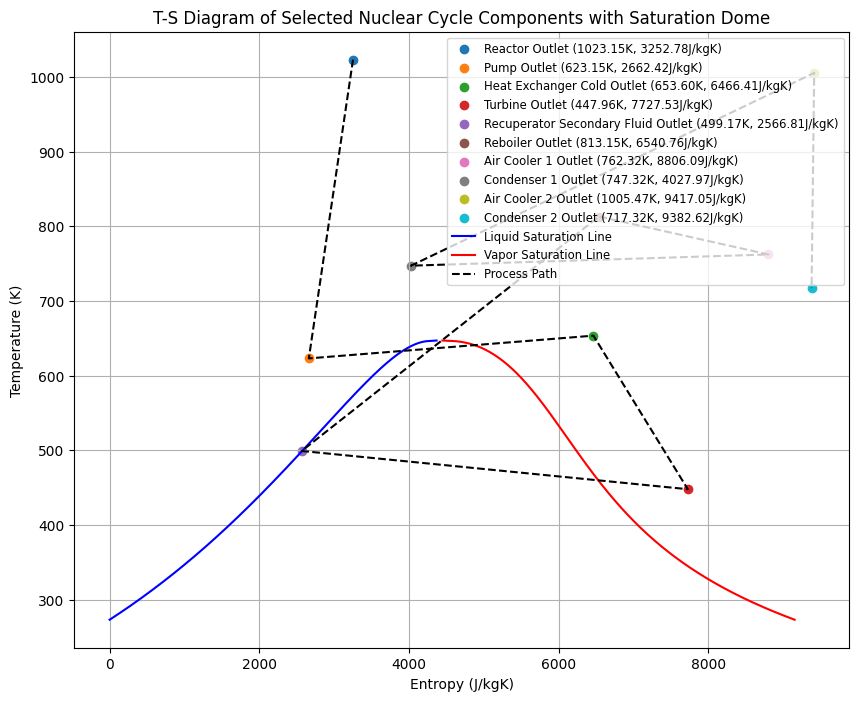

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import CoolProp.CoolProp as cp

# Define the temperatures and entropies for selected components in the order of the cycle
component_order = [
    "Reactor Outlet", "Pump Outlet", "Heat Exchanger Cold Outlet",
    "Turbine Outlet", "Recuperator Secondary Fluid Outlet",
    "Reboiler Outlet", "Air Cooler 1 Outlet", "Condenser 1 Outlet",
    "Air Cooler 2 Outlet", "Condenser 2 Outlet"
]

component_data = {
    "Reactor Outlet": (1023.15, 3252.78),
    "Pump Outlet": (623.15, 2662.42),
    "Heat Exchanger Cold Outlet": (653.60, 6466.41),
    "Turbine Outlet": (447.96, 7727.53),
    "Recuperator Secondary Fluid Outlet": (499.17, 2566.81),
    "Condenser 1 Outlet": (747.32, 4027.97),
    "Condenser 2 Outlet": (717.32, 9382.62),
    "Air Cooler 1 Outlet": (762.32, 8806.09),
    "Air Cooler 2 Outlet": (1005.47, 9417.05),
    "Reboiler Outlet": (813.15, 6540.76)
}

# Saturation curve data
T_sat = np.linspace(273.15, 647.096 - 0.01, 400)  # up to just below the critical temp
s_liq = np.array([cp.PropsSI('S', 'T', T, 'Q', 0, 'Water') for T in T_sat])
s_vap = np.array([cp.PropsSI('S', 'T', T, 'Q', 1, 'Water') for T in T_sat])

# Plotting the T-S diagram
plt.figure(figsize=(10, 8))
temperatures = []
entropies = []

for comp in component_order:
    temp, entropy = component_data[comp]
    plt.scatter(entropy, temp, label=f"{comp} ({temp:.2f}K, {entropy:.2f}J/kgK)")
    temperatures.append(temp)
    entropies.append(entropy)

plt.plot(s_liq, T_sat, 'b-', label='Liquid Saturation Line')
plt.plot(s_vap, T_sat, 'r-', label='Vapor Saturation Line')
plt.plot(entropies, temperatures, 'k--', label='Process Path')  # Connect the points

plt.title('T-S Diagram of Selected Nuclear Cycle Components with Saturation Dome')
plt.xlabel('Entropy (J/kgK)')
plt.ylabel('Temperature (K)')
plt.legend(loc='upper right', fontsize='small')  # Adjust legend position and font size
plt.grid(True)
plt.show()
